# Summative Lab- DataVine Analytics

## Step 1: Load and prepare the datasets

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

### Function Definitions

In [8]:
# Function Definitions
def load_csv(filename):
    # Load the dataset
    df =pd.read_csv(filename)
    return df

In [10]:
def find_and_analyze_outliers(data):
    """
    Identify and analyze outliers in numeric columns of a DataFrame.

    Parameters:
        data (pd.DataFrame): Input DataFrame containing numeric columns.

    Returns:
        df_outliers (pd.DataFrame): DataFrame containing rows with outliers.
        df_outliers_analyze (pd.DataFrame): DataFrame summarizing outlier count and percentage.
    """
    # Select numeric columns from the input DataFrame
    numeric_columns = data.select_dtypes(include=['float64', 'int64'])

    # Calculate the first quartile (Q1), third quartile (Q3), and interquartile range (IQR)
    Q1 = numeric_columns.quantile(0.25)
    Q3 = numeric_columns.quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds for outliers detection using IQR method
    inf_lim = Q1 - 1.5 * IQR
    sup_lim = Q3 + 1.5 * IQR

    # Identify outliers using lower and upper bounds
    outliers = ((numeric_columns < inf_lim) | (numeric_columns > sup_lim))

    # Count the number of outliers and calculate the percentage of outliers in each column
    outliers_count = outliers.sum()
    outliers_percentage = (outliers.sum() / len(numeric_columns)) * 100

    # Extract rows with any outlier in at least one numeric column
    df_outliers = data[outliers.any(axis=1)]

    # Create a DataFrame summarizing outlier count and percentage
    df_outliers_analyze = pd.DataFrame({
        'Outliers Count': outliers_count,
        'Outliers Percentage': outliers_percentage,
    })

    # Filter rows with non-zero outlier counts
    df_outliers_analyze = df_outliers_analyze[df_outliers_analyze['Outliers Count'] > 0]

    # Sort the DataFrame by 'Outliers Count' in descending order
    df_outliers_analyze = df_outliers_analyze.sort_values(by='Outliers Count', ascending=False)

    # Return DataFrame with outliers and summary DataFrame
    return df_outliers, df_outliers_analyze

In [12]:
# Function to calculate cosine similarity
def cos_sim(pca_df, comp='1'):
    """
    Calculate cosine distance matrix for feeds using PCA components.
    Returns a DataFrame with feed names as index and columns.
    """
    if comp == '1':
        data = pca_df[['pca_value_1']]
    else:
        data = pca_df[['pca_value_1', 'pca_value_2']]
    cosine_sim_matrix = cosine_similarity(data)
    cosine_dist_matrix = 1 - cosine_sim_matrix
    return pd.DataFrame(cosine_dist_matrix, index=pca_df['feed_name'], columns=pca_df['feed_name'])

In [110]:
def weighted_hybrid_distances(X, weights=1):
    """
    Calculate a weighted hybrid distance matrix from multiple distance metrics
    
    Parameters:
    X: feature matrix (normalized)
    weights: list of weights for [euclidean, manhattan, cosine]
    
    Returns:
    Weighted hybrid distance matrix
    """
    # Calculate individual distance matrices
    cos_dist = 1 - cosine_similarity(X)
    
    # Normalize each distance matrix to [0,1] range for fair weighting
    # For this simple example with normalized features, we'll just use the raw distances
    
    # Return weighted combination
    return (weights * cos_dist)

In [114]:
def recommend_similar_feeds(feed_name, cosine_sim_df, top_n=5):
    """
    Recommend similar feeds based on cosine similarity scores.
    
    Parameters:
    - feed_name: The name of the feed to find similar feeds for.
    - cosine_sim_df: DataFrame containing cosine similarity scores.
    - top_n: Number of top similar feeds to recommend.
    
    Returns:
    - List of recommended feed names.
    """
    if feed_name not in cosine_sim_df.index:
        return "Feed not found in the database."
    
    # Get the distances for the specified feed
    distances = cosine_sim_df.loc[feed_name].copy()
    # Set the distance to itself as infinity so it's not selected
    distances[feed_name] = float('inf')
    # Get indices of n most similar feeds (smallest distances)
    most_similar_idx = distances.nsmallest(top_n).index
    # Return feed names and their distances
    similar_feeds = [f"{name} (distance: {distances[name]:.4f})" for name in most_similar_idx]
    return similar_feeds

In [14]:
# Load the Datasets
wine_data=load_csv("wine_data.csv")
arrest_data=load_csv("arrests_data.csv")
chick_data=load_csv("chickwts_data.csv")
# Get basic information about the dataset
wine_data.info()
chick_data.info()
arrest_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [16]:
# Check the first few rows of the dataset
wine_data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [18]:
# Check the first few rows of the dataset
chick_data.head()

,feed_name,proteinContent,fatContent,fiberContent,calciumContent,phosphorusContent,moistureContent,ashContent,metabolizableEnergy,lysineContent,methionineContent,particleSize,density,price,shelfLife,weight
0,FirstPeck,19.5,3.2,2.4,0.82,0.78,10.8,4.5,2921,0.96,0.43,3.5,0.57,1.71,295,16.285714
1,ChickStart Plus,18.2,3.8,3.9,3.02,0.68,9.3,6.9,2865,0.99,0.37,3.4,0.70,1.67,302,20.588235
2,EarlyGrow Formula,19.3,4.6,3.2,1.20,0.69,10.2,5.8,2950,1.05,0.38,3.3,0.69,1.65,331,20.909091
3,HatchMate Premier,20.2,3.7,3.8,3.16,0.63,11.4,5.7,2866,1.11,0.38,3.2,0.74,1.71,292,23.125000
4,PeepNourish,19.2,3.9,4.2,3.06,0.61,9.3,5.9,2860,0.91,0.34,2.9,0.64,1.67,309,22.068966


In [20]:
# Check the first few rows of the dataset
arrest_data.head()

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [22]:
# Check for missing values
print(f"Does Wine data have any null Values?: {wine_data.isnull().any().any()}")
print(f"Does Chicken Weights data have any null Values?: {chick_data.isnull().any().any()}")
print(f"Does Arrest data have any null Values?: {arrest_data.isnull().any().any()}")

Does Wine data have any null Values?: False
Does Chicken Weights data have any null Values?: False
Does Arrest data have any null Values?: False


In [24]:
# Check for duplicates
print(f"Number of duplicate rows in Wine Dataset: {wine_data.duplicated().sum()}")
print(f"Number of duplicate rows in Chicken Weights Dataset: {chick_data.duplicated().sum()}")
print(f"Number of duplicate rows in Arrest Dataset: {arrest_data.duplicated().sum()}")

Number of duplicate rows in Wine Dataset: 0
Number of duplicate rows in Chicken Weights Dataset: 0
Number of duplicate rows in Arrest Dataset: 0


In [26]:
# Check basic statistics of the dataset
wine_data.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [28]:
# Check basic statistics of the dataset
chick_data.describe()

,proteinContent,fatContent,fiberContent,calciumContent,phosphorusContent,moistureContent,ashContent,metabolizableEnergy,lysineContent,methionineContent,particleSize,density,price,shelfLife,weight
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,18.874000,3.990000,3.594000,1.668800,0.647800,10.418000,5.625000,2911.280000,0.942700,0.378500,2.529000,0.649500,1.654600,313.270000,27.147503
std,2.099332,0.707607,0.694832,1.177822,0.090716,0.854268,0.831498,102.461333,0.121172,0.054018,0.580716,0.055421,0.069201,12.668146,7.082035
min,15.000000,2.300000,2.300000,0.670000,0.400000,9.000000,4.100000,2711.000000,0.690000,0.260000,1.500000,0.550000,1.510000,290.000000,16.285714
25%,17.300000,3.500000,3.100000,0.855000,0.580000,9.800000,4.900000,2851.500000,0.860000,0.340000,2.000000,0.610000,1.610000,303.000000,22.000000
50%,19.050000,3.950000,3.600000,0.995000,0.645000,10.300000,5.650000,2897.500000,0.930000,0.380000,2.600000,0.650000,1.650000,313.500000,24.533333
75%,20.500000,4.500000,4.100000,3.037500,0.712500,11.200000,6.325000,2973.250000,1.022500,0.420000,3.000000,0.692500,1.690000,323.000000,31.013158
max,23.400000,5.700000,5.000000,3.950000,0.840000,11.900000,7.000000,3165.000000,1.240000,0.500000,3.500000,0.750000,1.830000,337.000000,46.250000


In [30]:
# Check basic statistics of the dataset
arrest_data.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


In [32]:
#Shape of the dataset
print("\n--- Shape of the Dataset ---")
print(f"Number of duplicate rows in Wine Dataset: {wine_data.shape}")
print(f"Number of duplicate rows in Chicken Weights Dataset: {chick_data.shape}")
print(f"Number of duplicate rows in Arrest Dataset: {arrest_data.shape}")


--- Shape of the Dataset ---
Number of duplicate rows in Wine Dataset: (178, 14)
Number of duplicate rows in Chicken Weights Dataset: (100, 16)
Number of duplicate rows in Arrest Dataset: (50, 5)


## Step 2: k-NN classificayion on the Wine Dataset

In [35]:
# Check the distribution of the target variable
wine_data['target'].value_counts(normalize=True)

target
1    0.398876
0    0.331461
2    0.269663
Name: proportion, dtype: float64

In [37]:
# Select all numeric columns except the target
numeric_columns = wine_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('target')
numeric_columns

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

### Visualization

<Figure size 1500x1000 with 0 Axes>

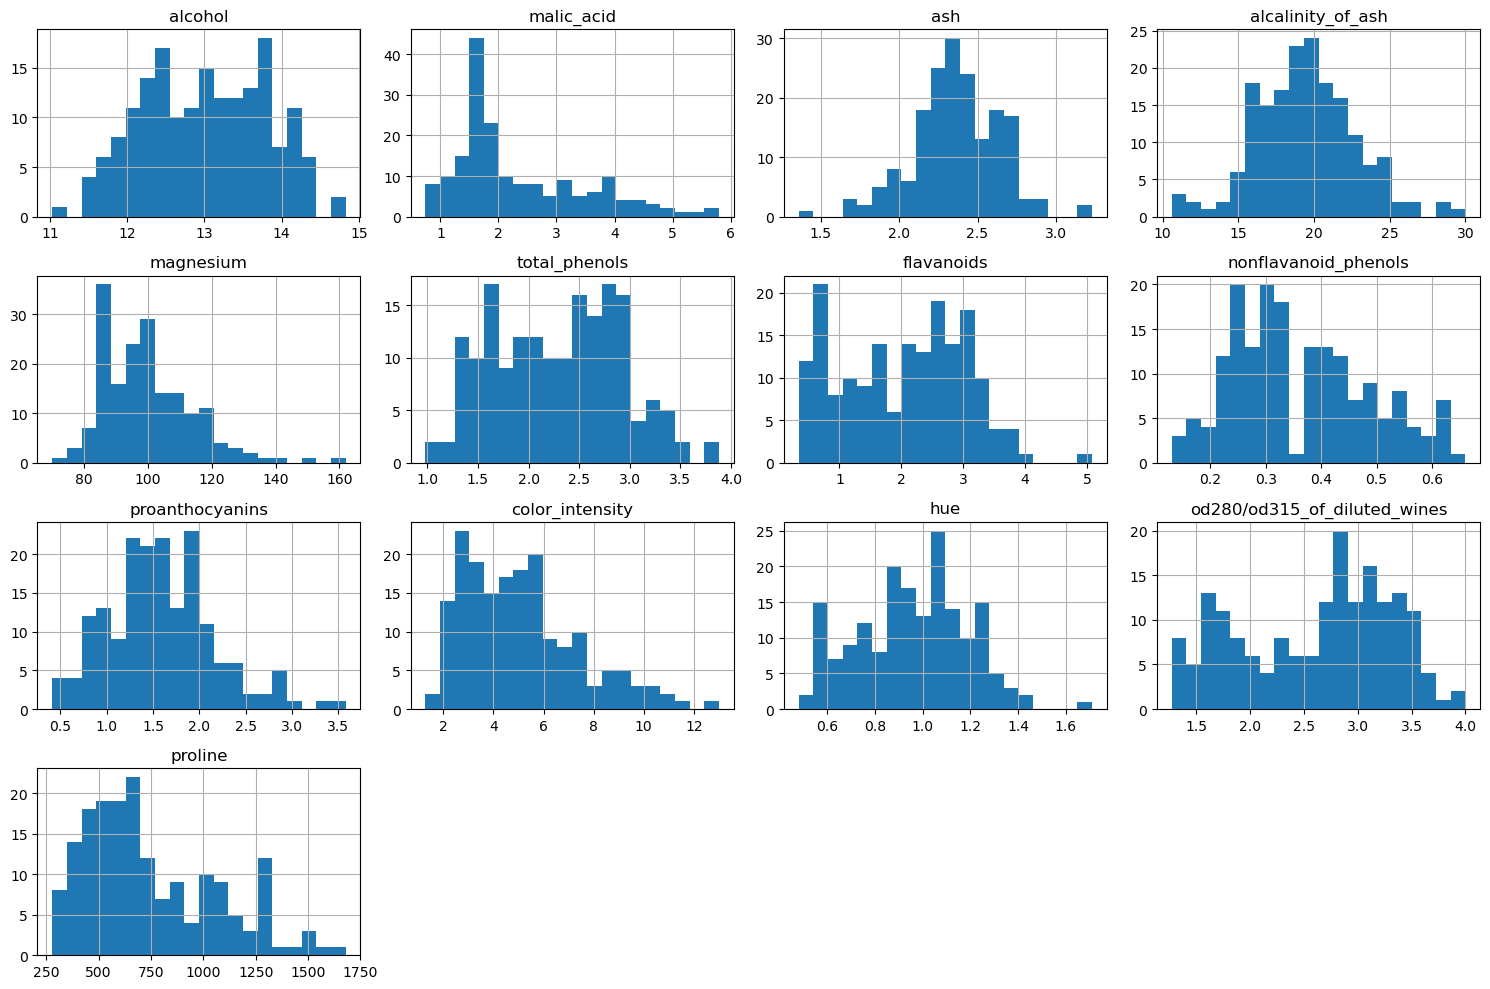

In [40]:
# Plot histograms
plt.figure(figsize=(15, 10))
wine_data[numeric_columns].hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show();

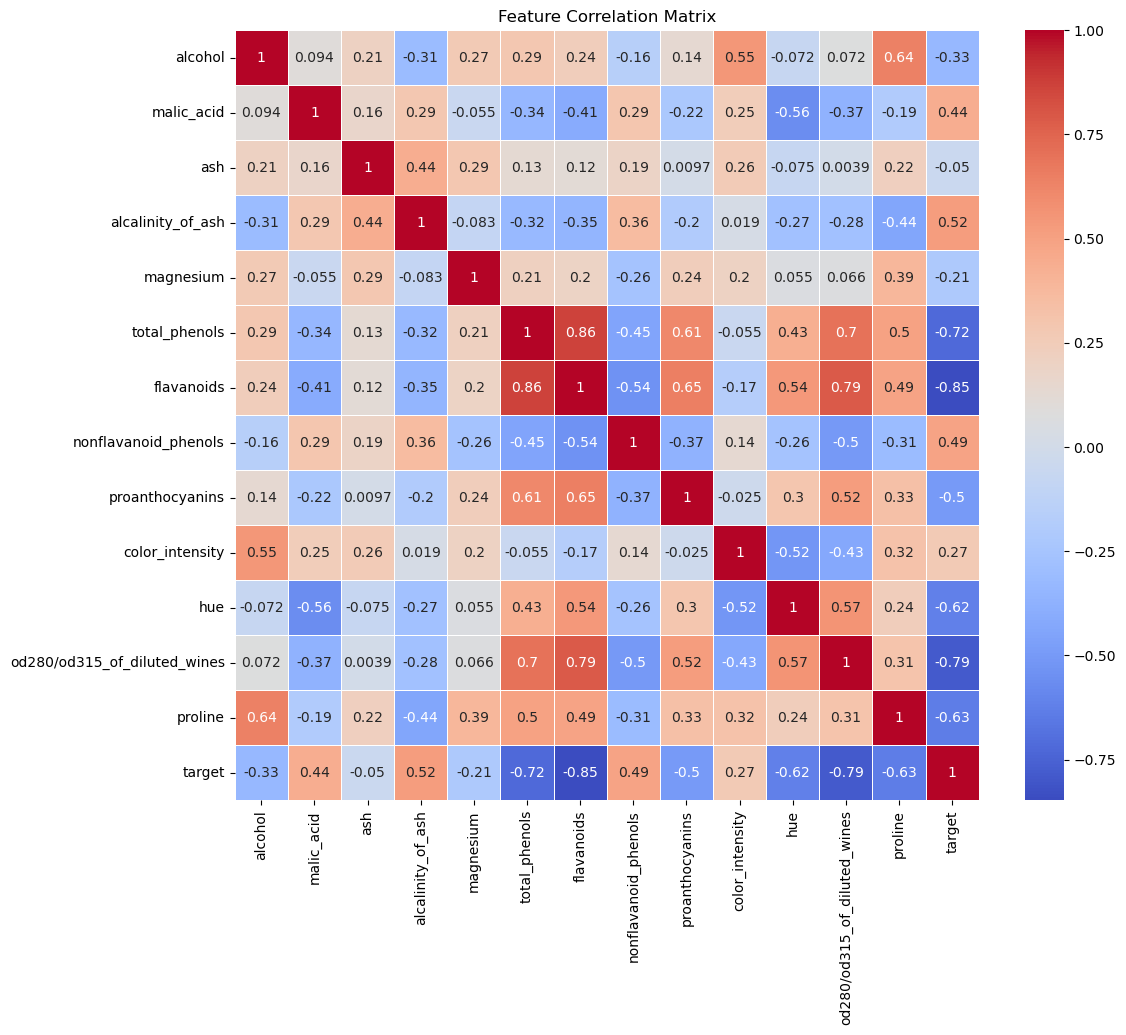

In [41]:
# Create a correlation matrix to identify feature relationships
correlation_matrix = wine_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show();

### Outlier analysis

In [45]:
df_outliers, df_outliers_analyze = find_and_analyze_outliers(wine_data)
df_outliers_analyze

,Outliers Count,Outliers Percentage
alcalinity_of_ash,4,2.247191
magnesium,4,2.247191
color_intensity,4,2.247191
malic_acid,3,1.685393
ash,3,1.685393
proanthocyanins,2,1.123596
hue,1,0.561798


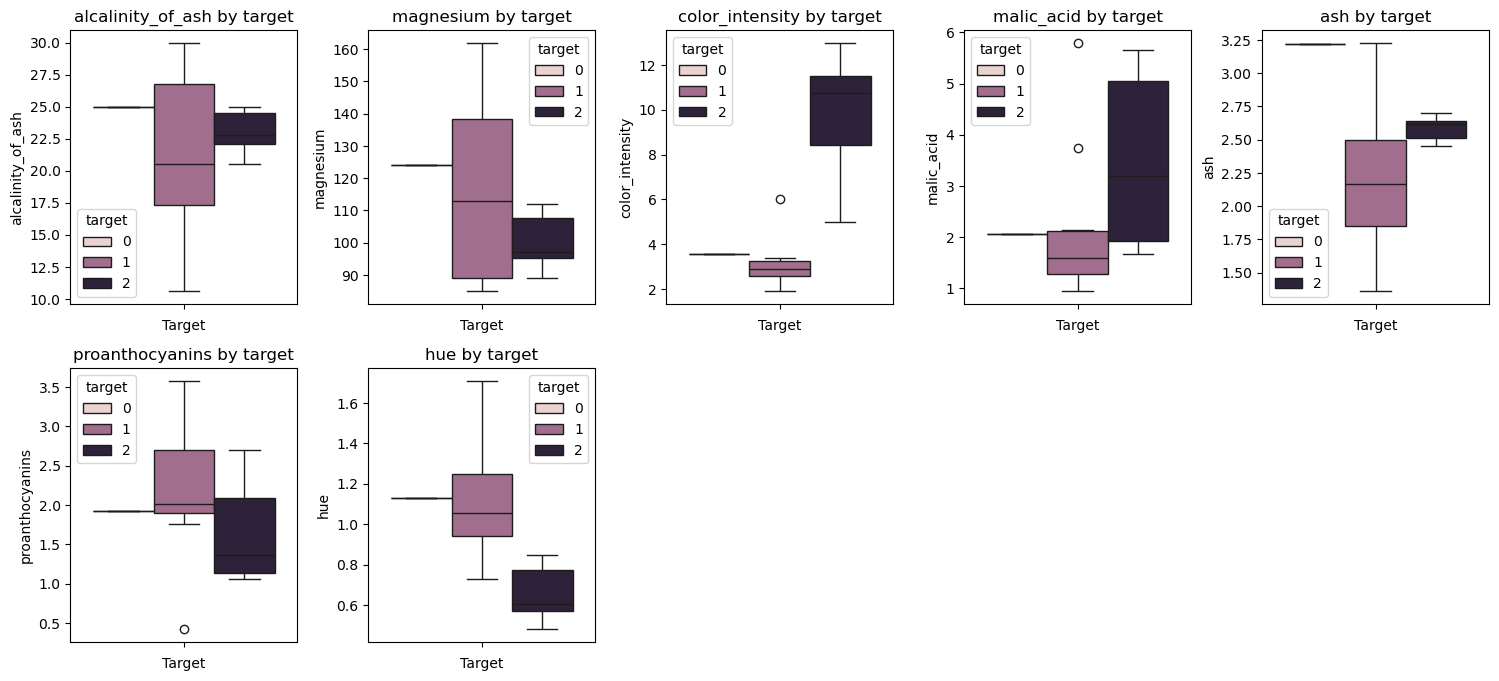

In [47]:
features = df_outliers_analyze.index.tolist()
# Set the size of the overall figure
plt.figure(figsize=(15, 10))

# Iterate through the specified features and create subplots
for i, feature in enumerate(features):
    plt.subplot(3, 5, i + 1)
    # Create a boxplot for the current feature, optionally grouped by 'target'
    sns.boxplot(y=feature, hue='target', data=df_outliers)

    # Set the title, x-axis label, and y-axis label for the subplot
    plt.title(f'{feature} by target')
    plt.xlabel('Target')
    plt.ylabel(feature)

# Adjust subplot layout for better visualization
plt.tight_layout()

# Display the figure with subplots
plt.show()

#### Analysis
* Features have different scales. When features have significantly different scales, features with larger ranges will dominate the distance calculations in KNN. Scaling is needed.
* Data has outliers. Outliers can distort distance calculations, affect the direction of principal components, and reduce model accuracy.

In [50]:
# Make a copy of the data
df_wine_orig_copy = wine_data.copy()
df_wine_without_outliers = wine_data.copy()
#Drop outliers
df_wine_without_outliers.drop(labels= df_outliers.index, inplace = True)
wine_data = df_wine_without_outliers.copy()
wine_data.shape

(161, 14)

### Standardize

In [53]:
# Split the dataset into features and target variable
X = wine_data.drop('target', axis=1)
y = wine_data['target']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [55]:
# Display a comparison of original vs. scaled data for the first sample
print("Original first sample:")
print(X_train.iloc[0].values[:5], "...")
print("\nScaled first sample:")
print(X_train_scaled[0][:5], "...")

Original first sample:
[12.07  2.16  2.17 21.   85.  ] ...

Scaled first sample:
[-1.18525204 -0.15864366 -0.85707086  0.56317828 -1.09584225] ...


### PCA for Wine Dataset

In [58]:
# Initialize PCA without restricting the number of components (default)
pca = PCA()

# Fit PCA model to data
pca.fit(X_train_scaled)

# Transform the data to the new PC space
X_pca = pca.transform(X_train_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(
    data=X_pca,
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])]
)
pca_df['target'] = y

# Look at the transformed data
print("First 5 rows of PCA-transformed data:")
print(pca_df.head())

First 5 rows of PCA-transformed data:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.183926 -2.285016  0.116700  1.010005 -0.126390 -0.179557  0.045196   
1  2.609257  0.918536  1.055737  0.719267  0.706962 -0.812504  0.241952   
2 -2.342879 -0.458018 -1.551254 -0.974063  1.051097 -1.020231  0.605697   
3  2.855420  1.179812 -0.424755  1.475684  0.424318  1.102591  0.094381   
4  0.518839  0.419990 -0.038923  1.518905 -0.377137  1.028472  0.689134   

        PC8       PC9      PC10      PC11      PC12      PC13  target  
0 -0.846781 -0.892459  0.139740  0.108795 -0.114629  0.324722     0.0  
1  0.175232  1.276193  0.249364  0.029654  0.138963  0.155112     0.0  
2 -0.769493  0.292553 -0.041537 -0.388029 -0.575574 -0.624994     0.0  
3  0.302983 -0.273907 -0.099705  0.156272 -0.276655 -0.218030     0.0  
4 -0.211191 -0.285511 -0.223889 -0.018621 -0.154489  0.222994     0.0  


In [60]:
# Examine explained variance
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Create a dataframe for better display
variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Eigenvalue': explained_variance,
    'Variance Explained (%)': explained_variance_ratio * 100,
    'Cumulative Variance Explained (%)': cumulative_variance_ratio * 100
})

print("Variance explained by each principal component:")
print(variance_df)

Variance explained by each principal component:
   Principal Component  Eigenvalue  Variance Explained (%)  \
0                  PC1    5.041779               38.479927   
1                  PC2    2.539238               19.379999   
2                  PC3    1.385214               10.572244   
3                  PC4    0.913048                6.968574   
4                  PC5    0.755041                5.762636   
5                  PC6    0.610399                4.658691   
6                  PC7    0.472286                3.604590   
7                  PC8    0.352022                2.686705   
8                  PC9    0.327384                2.498661   
9                 PC10    0.262300                2.001926   
10                PC11    0.213343                1.628280   
11                PC12    0.162279                1.238551   
12                PC13    0.068030                0.519216   

    Cumulative Variance Explained (%)  
0                           38.479927  
1  

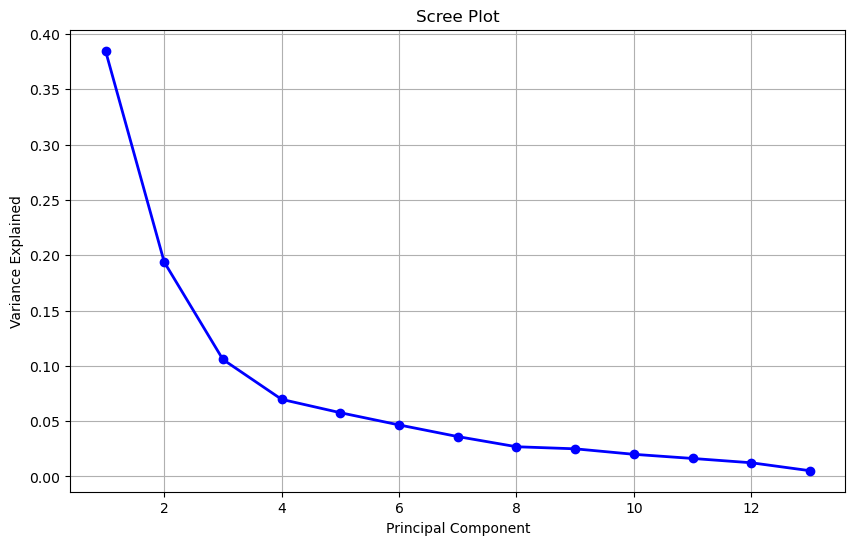

In [62]:
# Create scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

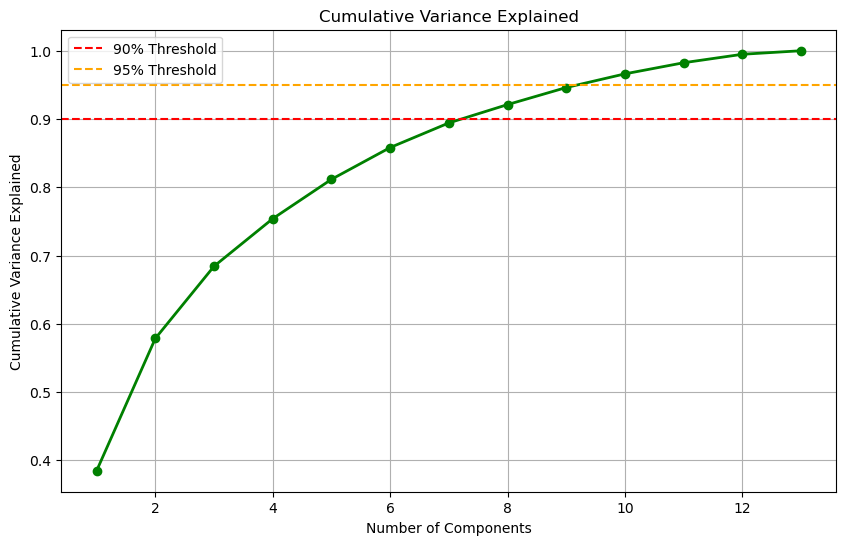

In [64]:
# Create cumulative variance plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'o-', linewidth=2, color='green')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Threshold')
plt.axhline(y=0.95, color='orange', linestyle='--', label='95% Threshold')
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

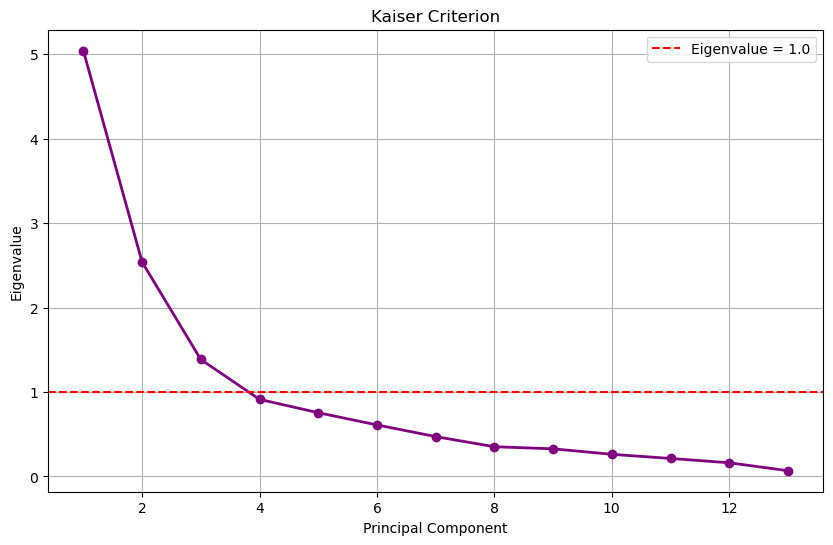

In [66]:
# Create Kaiser criterion plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o-', linewidth=2, color='purple')
plt.axhline(y=1.0, color='r', linestyle='--', label='Eigenvalue = 1.0')
plt.title('Kaiser Criterion')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
# Determine optimal number of components based on different methods

# 1. Based on cumulative variance threshold (e.g., 95%)
target_variance = 0.95
n_components_variance = np.argmax(cumulative_variance_ratio >= target_variance) + 1
print(f"Number of components needed to explain {target_variance*100}% of variance: {n_components_variance}")

# 2. Based on Kaiser criterion (eigenvalues > 1)
n_components_kaiser = sum(explained_variance > 1.0)
print(f"Number of components with eigenvalues > 1: {n_components_kaiser}")

# Select the optimal number of components
n_components_optimal = n_components_variance  

# Create a new PCA instance with optimal number of components
pca_optimal = PCA(n_components=n_components_optimal)
X_pca_optimal = pca_optimal.fit_transform(X_train_scaled)

# Display dimensionality reduction summary
print(f"\nOriginal data shape: {X.shape}")
print(f"Reduced data shape: {X_pca_optimal.shape}")
print(f"Dimensionality reduction: {X.shape[1]} → {X_pca_optimal.shape[1]}")

Number of components needed to explain 95.0% of variance: 10
Number of components with eigenvalues > 1: 3

Original data shape: (161, 13)
Reduced data shape: (128, 10)
Dimensionality reduction: 13 → 10


Component loadings (how features contribute to PCs):
                                   PC1       PC2       PC3       PC4  \
alcohol                       0.169265  0.471896 -0.167777  0.026910   
malic_acid                   -0.219876  0.238129  0.125386  0.627807   
ash                          -0.000173  0.264366  0.699658 -0.134968   
alcalinity_of_ash            -0.278346 -0.059823  0.521595  0.123034   
magnesium                     0.122735  0.377915  0.275510 -0.360376   
total_phenols                 0.389154  0.029023  0.113744  0.191381   
flavanoids                    0.424012 -0.048605  0.059469  0.139930   
nonflavanoid_phenols         -0.290138  0.016207 -0.036955 -0.166126   
proanthocyanins               0.342404 -0.018494  0.042097  0.353267   
color_intensity              -0.072686  0.514851 -0.243987  0.041780   
hue                           0.283095 -0.275491  0.088057 -0.391387   
od280/od315_of_diluted_wines  0.367543 -0.155263  0.152191  0.205706   
proline    

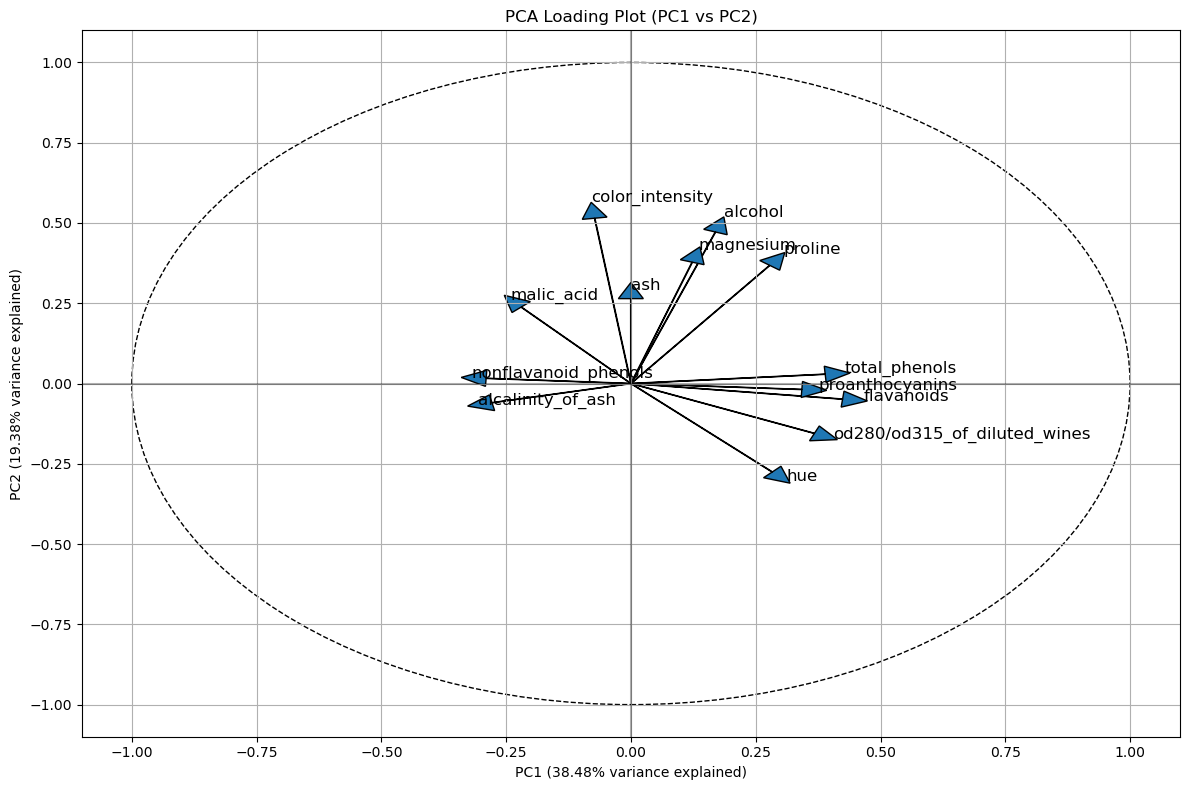

In [70]:
# Get the loadings (weights) of each feature for each principal component
feature_names = [col for col in wine_data.columns if col != 'target']

loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=feature_names
)

print("Component loadings (how features contribute to PCs):")
print(loadings)
# Visualize the loadings for the first two PCs
plt.figure(figsize=(12, 8))
for i, feature in enumerate(feature_names):
    plt.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1], head_width=0.05, head_length=0.05)
    plt.text(loadings.iloc[i, 0]*1.1, loadings.iloc[i, 1]*1.1, feature, fontsize=12)

# Add a unit circle for reference
circle = plt.Circle((0, 0), 1, fill=False, linestyle='--')
plt.gca().add_patch(circle)

plt.grid(True)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.title('PCA Loading Plot (PC1 vs PC2)')
plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.2%} variance explained)')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.2%} variance explained)')
plt.tight_layout()
plt.show()

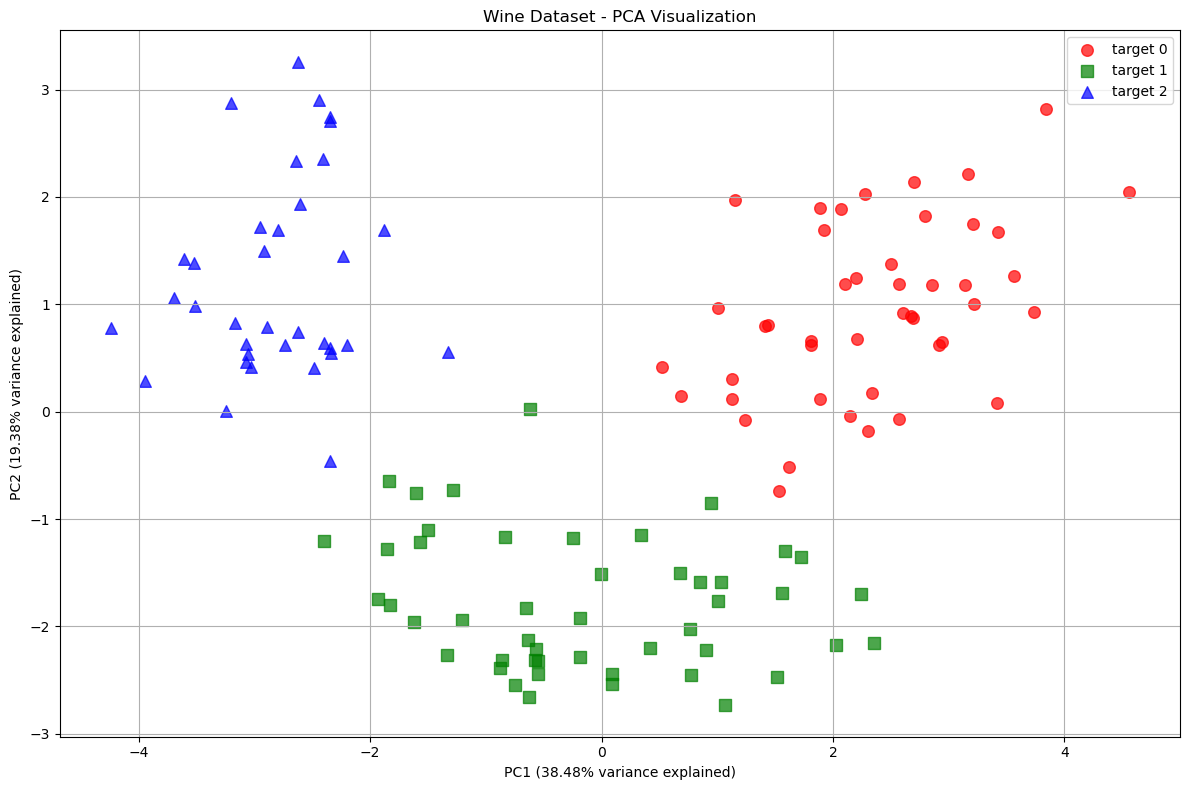

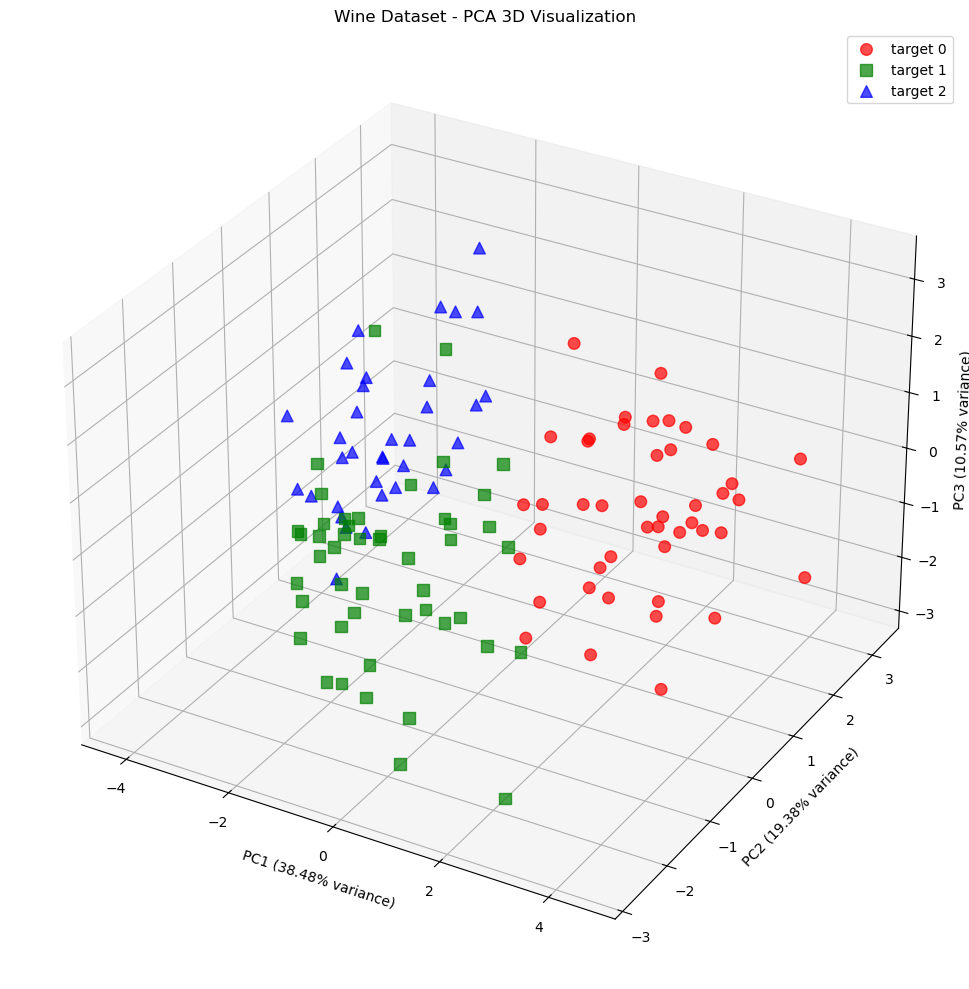


Mean squared reconstruction error: 0.0343
This represents the information loss from using 10 instead of 13 components.


In [72]:
# Create a 2D scatter plot of the transformed data
plt.figure(figsize=(12, 8))
colors = ['red', 'green', 'blue']
markers = ['o', 's', '^']

for i, (color, marker) in enumerate(zip(colors, markers)):
    indices = y_train == i
    plt.scatter(
        X_pca_optimal[indices, 0],
        X_pca_optimal[indices, 1] if X_pca_optimal.shape[1] > 1 else np.zeros(sum(indices)),
        color=color,
        marker=marker,
        s=70,
        alpha=0.7,
        label=f'target {i}'
    )

plt.title('Wine Dataset - PCA Visualization')
plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.2%} variance explained)')
if X_pca_optimal.shape[1] > 1:
    plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.2%} variance explained)')
else:
    plt.ylabel('Dimension 2 (not used)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# If we kept more than 2 components, create a 3D plot
if X_pca_optimal.shape[1] > 2:
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    for i, (color, marker) in enumerate(zip(colors, markers)):
        indices = y_train == i
        ax.scatter(
            X_pca_optimal[indices, 0],
            X_pca_optimal[indices, 1],
            X_pca_optimal[indices, 2],
            color=color,
            marker=marker,
            s=70,
            alpha=0.7,
        label=f'target {i}'
        )
    
    ax.set_title('Wine Dataset - PCA 3D Visualization')
    ax.set_xlabel(f'PC1 ({explained_variance_ratio[0]:.2%} variance)')
    ax.set_ylabel(f'PC2 ({explained_variance_ratio[1]:.2%} variance)')
    ax.set_zlabel(f'PC3 ({explained_variance_ratio[2]:.2%} variance)')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Optional: Reconstruct the original data from the PCA representation
# This shows how well the reduced representation preserves the original data
X_reconstructed = pca_optimal.inverse_transform(X_pca_optimal)
X_reconstructed_std = StandardScaler().fit_transform(X_reconstructed)

# Calculate reconstruction error
reconstruction_error = np.mean((X_train_scaled - X_reconstructed_std) ** 2)
print(f"\nMean squared reconstruction error: {reconstruction_error:.4f}")
print(f"This represents the information loss from using {n_components_optimal} instead of {X.shape[1]} components.")

### k-NN Classifier

In [75]:
# KNN Classifier
knn = KNeighborsClassifier()
# Define hyperparameters for tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
# Perform Grid Search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_pca_optimal, y_train)
# Get the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score:.4f}")

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Best cross-validation score: 0.9769


In [77]:
# Train the KNN model with the best parameters
knn_best = KNeighborsClassifier(**best_params)
knn_best.fit(X_pca_optimal, y_train)
# Make predictions on the test set
X_test_pca = pca_optimal.transform(X_test_scaled)
y_pred = knn_best.predict(X_test_pca)

In [79]:
# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.92      0.96        13
           2       0.88      1.00      0.93         7

    accuracy                           0.97        33
   macro avg       0.96      0.97      0.96        33
weighted avg       0.97      0.97      0.97        33

Confusion Matrix:
[[13  0  0]
 [ 0 12  1]
 [ 0  0  7]]
Accuracy Score: 0.9696969696969697


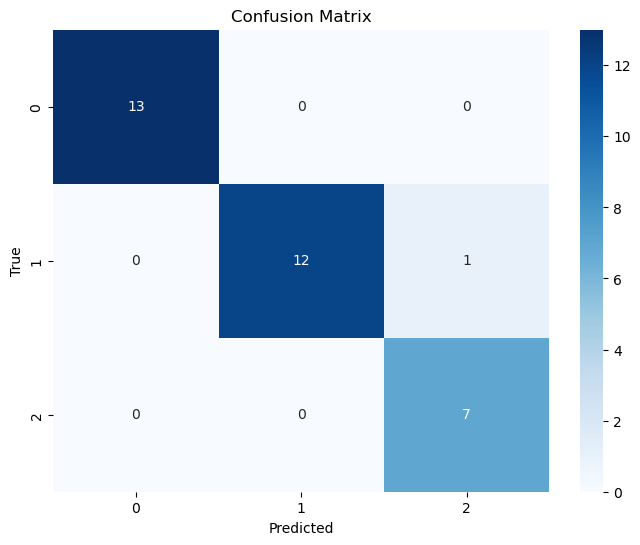

In [81]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Conclusion:
This program successfully demonstrates a complete machine learning workflow on the wine dataset, including data exploration, outlier detection and removal, feature scaling, dimensionality reduction with PCA, and classification using a tuned k-NN model. After cleaning and transforming the data, the model achieved a high accuracy score of 0.97 on the test set. Visualizations such as PCA plots and confusion matrices provided insights into the data structure and model performance. Overall, the program highlights the importance of preprocessing and dimensionality reduction for building accurate and interpretable classification models.

#### Reconstruction Error
A mean squared reconstruction error of 0.0343 demonstrates that PCA has compressed the data efficiently while retaining its essential structure for modeling and analysi
#### Confusion Matrix Interpretation
Class 0: All 13 samples correctly classified (no misclassifications).
Class 1: 12 correctly classified, 1 misclassified as class 2.
Class 2: All 7 samples correctly classified.
#### Classification Report¶
High precision and recall (close to 1.0) for a class means the model is both accurate and complete in identifying that class.
High F1-score means the model performs well for that class.

## Step 3: Recommendation System on Chicken Weights Dataset

### Standardization

In [86]:
# Numerical features
numerical_features = chick_data.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('weight')
feature_matrix = chick_data[numerical_features].values

In [88]:
# Standardize the numerical features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(feature_matrix)
# Create a DataFrame with normalized features for better visualization
normalized_df = pd.DataFrame(
    normalized_features, 
    columns=numerical_features, 
    index=chick_data['feed_name']
)
print("\nNormalized Features:")
print(normalized_df)


Normalized Features:
                         proteinContent  fatContent  fiberContent  \
feed_name                                                           
FirstPeck                      0.299692   -1.122064     -1.727057   
ChickStart Plus               -0.322672   -0.269863      0.442613   
EarlyGrow Formula              0.203944    0.866404     -0.569900   
HatchMate Premier              0.634811   -0.411897      0.297968   
PeepNourish                    0.156070   -0.127830      0.876547   
...                                 ...         ...           ...   
FertileSupport Enhanced       -1.184407    0.724370     -0.135966   
HatchPro Complete              0.395441   -0.980031      0.587257   
BreederOptimal Formula         1.544421    0.724370     -0.714545   
ClutchPower Premium           -0.705665   -0.837997      1.310481   
BreederAdvance Complete       -0.274798    1.292504     -0.135966   

                         calciumContent  phosphorusContent  moistureContent  \
f

In [90]:
# Standardize the weight feature
weight = chick_data['weight'].values.reshape(-1, 1)
weight_scaled = scaler.fit_transform(weight)
# Add the scaled weight feature to the feature matrix
scaled_features = np.hstack((normalized_features, weight_scaled))

scaled_df = pd.DataFrame(
    scaled_features, 
    columns=numerical_features+ ['weight'], 
    index=chick_data['feed_name']
)
print("\nScaled Features:")
print(scaled_df)


Scaled Features:
                         proteinContent  fatContent  fiberContent  \
feed_name                                                           
FirstPeck                      0.299692   -1.122064     -1.727057   
ChickStart Plus               -0.322672   -0.269863      0.442613   
EarlyGrow Formula              0.203944    0.866404     -0.569900   
HatchMate Premier              0.634811   -0.411897      0.297968   
PeepNourish                    0.156070   -0.127830      0.876547   
...                                 ...         ...           ...   
FertileSupport Enhanced       -1.184407    0.724370     -0.135966   
HatchPro Complete              0.395441   -0.980031      0.587257   
BreederOptimal Formula         1.544421    0.724370     -0.714545   
ClutchPower Premium           -0.705665   -0.837997      1.310481   
BreederAdvance Complete       -0.274798    1.292504     -0.135966   

                         calciumContent  phosphorusContent  moistureContent  \
feed_

### PCA - One Component

In [93]:
# Apply PCA to reduce data to 1 principal components
pca = PCA(n_components=1)
pca.fit(scaled_df)
# Transform the data
feature_matrix_pca = pca.transform(scaled_df)

In [101]:
# Create a DataFrame with the principal components
pca_df = pd.DataFrame({
    'feed_name': chick_data['feed_name'],
    'pca_value_1': feature_matrix_pca[:, 0]  # Added column names
    #'pca_value_2': feature_matrix_pca[:, 1]
}).groupby('feed_name').mean()
# Reset index to make 'feed_name' a column
pca_df.reset_index(inplace=True)

# Look at the transformed data
print("First 5 rows of PCA-transformed data:")
print(pca_df.head())

First 5 rows of PCA-transformed data:
                 feed_name  pca_value_1
0            BabyBirdBlend    -1.729711
1  BreederAdvance Complete     0.765590
2   BreederChoice Complete    -5.220305
3    BreederElite Complete     0.657041
4   BreederOptimal Formula     3.529036


#### Cosine Similarities

In [103]:
cosine_dist_matrix = cos_sim(pca_df,'1')

In [108]:
# Create a df for visualization
cosine_sim_df = pd.DataFrame(cosine_dist_matrix, index=pca_df['feed_name'], columns=pca_df['feed_name'])
cosine_sim_df

feed_name,BabyBirdBlend,BreederAdvance Complete,BreederChoice Complete,BreederElite Complete,BreederOptimal Formula,BreederPerfect Plus,BreederPrime Formula,BreederVital Premium,BroilerBoost Supreme,BroilerBulk Ultra,...,ReproMax Enhanced,ReproNutrient Formula,ReproSuccess Formula,ShellBuilder Pro,ShellMax Enhanced,ShellStrength Pro,StartRight Formula,TeenChick Formula,WeightGain Pro,YolkPerfect Premium
feed_name,,,,,,,,,,,,,,,,,,,,,
BabyBirdBlend,0.0,2.0,0.0,2.0,2.0,0.0,2.0,0.0,2.0,2.0,...,0.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0
BreederAdvance Complete,2.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
BreederChoice Complete,0.0,2.0,0.0,2.0,2.0,0.0,2.0,0.0,2.0,2.0,...,0.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0
BreederElite Complete,2.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
BreederOptimal Formula,2.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ShellStrength Pro,2.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
StartRight Formula,2.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
TeenChick Formula,2.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0


In [112]:

# Calculate hybrid distance matrix with scikit-learn
hybrid_matrix = weighted_hybrid_distances(feature_matrix_pca)
hybrid_df = pd.DataFrame(hybrid_matrix, index=chick_data['feed_name'], columns=chick_data['feed_name'])

print("\nHybrid Distance Matrix:")
hybrid_df.round(4)


Hybrid Distance Matrix:


feed_name,FirstPeck,ChickStart Plus,EarlyGrow Formula,HatchMate Premier,PeepNourish,NestStart Gold,FledglingBlend,ChickBoost Complete,HatchlingEssentials,FirstFeather Nutrition,...,EggQuality Enhanced,BreederPerfect Plus,ReproNutrient Formula,FecundityBoost Complete,BreederVital Premium,FertileSupport Enhanced,HatchPro Complete,BreederOptimal Formula,ClutchPower Premium,BreederAdvance Complete
feed_name,,,,,,,,,,,,,,,,,,,,,
FirstPeck,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0
ChickStart Plus,2.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
EarlyGrow Formula,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0
HatchMate Premier,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0
PeepNourish,2.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FertileSupport Enhanced,2.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
HatchPro Complete,2.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
BreederOptimal Formula,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0


In [118]:
# Example usage
feed_name = 'PeepNourish'
similar_feeds = recommend_similar_feeds(feed_name, cosine_sim_df, top_n=5)
print(f"Similar feeds to '{feed_name}': {similar_feeds}")


Similar feeds to 'PeepNourish': ['BabyBirdBlend (distance: 0.0000)', 'BreederChoice Complete (distance: 0.0000)', 'BreederPerfect Plus (distance: 0.0000)', 'BreederVital Premium (distance: 0.0000)', 'ChickStart Plus (distance: 0.0000)']


In [120]:
# Test the recommendation function with different metrics
test_feeds = ['ReproMax Enhanced', 'PrimeFinish Complete', 'GrowStrong Advanced', 'MuscleBuilder Pro']

print("\nFeed Name Recommendations:")
for feed in test_feeds:
    print(f"\nFor '{feed}':")
    print("Using Hybrid distance:")
    print("  " + "\n  ".join(recommend_similar_feeds(feed, cosine_sim_df, top_n=5)))


Feed Name Recommendations:

For 'ReproMax Enhanced':
Using Hybrid distance:
  BabyBirdBlend (distance: 0.0000)
  BreederChoice Complete (distance: 0.0000)
  BreederPerfect Plus (distance: 0.0000)
  BreederVital Premium (distance: 0.0000)
  ChickStart Plus (distance: 0.0000)

For 'PrimeFinish Complete':
Using Hybrid distance:
  BabyBirdBlend (distance: 0.0000)
  BreederChoice Complete (distance: 0.0000)
  BreederPerfect Plus (distance: 0.0000)
  BreederVital Premium (distance: 0.0000)
  ChickStart Plus (distance: 0.0000)

For 'GrowStrong Advanced':
Using Hybrid distance:
  BabyBirdBlend (distance: 0.0000)
  BreederChoice Complete (distance: 0.0000)
  BreederPerfect Plus (distance: 0.0000)
  BreederVital Premium (distance: 0.0000)
  ChickStart Plus (distance: 0.0000)

For 'MuscleBuilder Pro':
Using Hybrid distance:
  BabyBirdBlend (distance: 0.0000)
  BreederChoice Complete (distance: 0.0000)
  BreederPerfect Plus (distance: 0.0000)
  BreederVital Premium (distance: 0.0000)
  ChickStart

### PCA - Two Components

In [125]:
# Apply PCA to reduce data to 1 principal components
pca = PCA(n_components=2)
pca.fit(scaled_df)
# Transform the data
feature_matrix_pca = pca.transform(scaled_df)

In [127]:
# Create a DataFrame with the principal components
pca_df = pd.DataFrame({
    'feed_name': chick_data['feed_name'],
    'pca_value_1': feature_matrix_pca[:, 0],  # Added column names
    'pca_value_2': feature_matrix_pca[:, 1]
}).groupby('feed_name').mean()
# Reset index to make 'feed_name' a column
pca_df.reset_index(inplace=True)

# Look at the transformed data
print("First 5 rows of PCA-transformed data:")
print(pca_df.head())

First 5 rows of PCA-transformed data:
                 feed_name  pca_value_1  pca_value_2
0            BabyBirdBlend    -1.729711     1.418211
1  BreederAdvance Complete     0.765590     0.382178
2   BreederChoice Complete    -5.220305     0.063116
3    BreederElite Complete     0.657041     0.320993
4   BreederOptimal Formula     3.529036    -0.337753


#### Cosine Similarities

In [130]:
cosine_dist_matrix = cos_sim(pca_df,'2')

In [132]:
# Create a df for visualization
cosine_sim_df = pd.DataFrame(cosine_dist_matrix, index=pca_df['feed_name'], columns=pca_df['feed_name'])
cosine_sim_df

feed_name,BabyBirdBlend,BreederAdvance Complete,BreederChoice Complete,BreederElite Complete,BreederOptimal Formula,BreederPerfect Plus,BreederPrime Formula,BreederVital Premium,BroilerBoost Supreme,BroilerBulk Ultra,...,ReproMax Enhanced,ReproNutrient Formula,ReproSuccess Formula,ShellBuilder Pro,ShellMax Enhanced,ShellStrength Pro,StartRight Formula,TeenChick Formula,WeightGain Pro,YolkPerfect Premium
feed_name,,,,,,,,,,,,,,,,,,,,,
BabyBirdBlend,0.000000,1.408700,2.190901e-01,1.416499e+00,1.830189,1.114180,1.958292,0.003440,1.124706,1.701606,...,0.042175,0.961315,1.343217,1.998463,1.768146,1.881002,1.681607,1.421360,3.532001e-01,0.102404
BreederAdvance Complete,1.408700,0.000000,1.889251e+00,3.665120e-05,0.151906,1.860035,0.869178,1.331653,0.043488,0.062918,...,1.653721,0.103825,1.716957,0.642510,0.101700,1.071729,0.053611,0.000097,5.682911e-01,0.964525
BreederChoice Complete,0.219090,1.889251,-2.220446e-16,1.893134e+00,1.996530,0.468605,1.569823,0.273546,1.717152,1.992990,...,0.072532,1.593966,0.681321,1.745091,1.999796,1.392457,1.989337,1.895530,9.712982e-01,0.574414
BreederElite Complete,1.416499,0.000037,1.893134e+00,1.110223e-16,0.147401,1.855635,0.860695,1.339718,0.046021,0.059963,...,1.660176,0.107657,1.710962,0.634527,0.097971,1.063187,0.050880,0.000014,5.760296e-01,0.973083
BreederOptimal Formula,1.830189,0.151906,1.996530e+00,1.474006e-01,0.000000,1.459045,0.363759,1.781130,0.343341,0.020292,...,1.955370,0.475052,1.238683,0.201983,0.005352,0.532352,0.026218,0.144615,1.111798e+00,1.499426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ShellStrength Pro,1.881002,1.071729,1.392457e+00,1.063187e+00,0.532352,0.429390,0.020532,1.917182,1.359552,0.719007,...,1.707895,1.506840,0.253252,0.094131,0.626183,0.000000,0.745687,1.057843,1.930656e+00,1.999341
StartRight Formula,1.681607,0.053611,1.989337e+00,5.087977e-02,0.026218,1.649107,0.555939,1.618618,0.188993,0.000383,...,1.863122,0.295197,1.453332,0.359994,0.007925,0.745687,0.000000,0.049207,8.828111e-01,1.289252
TeenChick Formula,1.421360,0.000097,1.895530e+00,1.433331e-05,0.144615,1.852852,0.855395,1.344749,0.047640,0.058150,...,1.664188,0.110086,1.707187,0.629549,0.095673,1.057843,0.049207,0.000000,5.808848e-01,0.978435


In [134]:

# Calculate hybrid distance matrix with scikit-learn
hybrid_matrix = weighted_hybrid_distances(feature_matrix_pca)
hybrid_df = pd.DataFrame(hybrid_matrix, index=chick_data['feed_name'], columns=chick_data['feed_name'])

print("\nHybrid Distance Matrix:")
hybrid_df.round(4)


Hybrid Distance Matrix:


feed_name,FirstPeck,ChickStart Plus,EarlyGrow Formula,HatchMate Premier,PeepNourish,NestStart Gold,FledglingBlend,ChickBoost Complete,HatchlingEssentials,FirstFeather Nutrition,...,EggQuality Enhanced,BreederPerfect Plus,ReproNutrient Formula,FecundityBoost Complete,BreederVital Premium,FertileSupport Enhanced,HatchPro Complete,BreederOptimal Formula,ClutchPower Premium,BreederAdvance Complete
feed_name,,,,,,,,,,,,,,,,,,,,,
FirstPeck,0.0000,0.5608,0.0387,0.2458,1.0270,0.0034,1.1224,1.4375,0.0912,0.2598,...,1.6576,1.9416,0.0357,1.9635,1.1456,1.8152,1.1247,0.2685,1.9912,0.0184
ChickStart Plus,0.5608,-0.0000,0.3302,0.0789,0.1138,0.4882,1.9454,2.0000,0.9757,1.2790,...,1.9656,1.7161,0.3387,1.6635,0.1751,1.8783,0.1634,1.2914,1.5540,0.7402
EarlyGrow Formula,0.0387,0.3302,0.0000,0.0940,0.7504,0.0193,1.3912,1.6684,0.2414,0.4738,...,1.8398,1.9979,0.0001,2.0000,0.8673,1.9433,0.8464,0.4848,1.9892,0.1089
HatchMate Premier,0.2458,0.0789,0.0940,0.0000,0.3640,0.1941,1.7440,1.9204,0.5885,0.8832,...,1.9906,1.9313,0.0989,1.9024,0.4602,1.9951,0.4425,0.8960,1.8343,0.3849
PeepNourish,1.0270,0.1138,0.7504,0.3640,0.0000,0.9443,1.9888,1.8871,1.4415,1.6921,...,1.7354,1.3113,0.7615,1.2414,0.0071,1.5569,0.0048,1.7014,1.1053,1.2171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FertileSupport Enhanced,1.8152,1.8783,1.9433,1.9951,1.5569,1.8603,0.3254,0.1226,1.4993,1.2141,...,0.0276,0.0373,1.9394,0.0596,1.4542,0.0000,1.4730,1.2014,0.1154,1.6898
HatchPro Complete,1.1247,0.1634,0.8464,0.4425,0.0048,1.0423,1.9695,1.8377,1.5272,1.7594,...,1.6655,1.2168,0.8576,1.1453,0.0002,1.4730,0.0000,1.7677,1.0075,1.3116
BreederOptimal Formula,0.2685,1.2914,0.4848,0.8960,1.7014,0.3273,0.4128,0.7068,0.0508,0.0001,...,0.9673,1.4590,0.4751,1.5224,1.7811,1.2014,1.7677,0.0000,1.6350,0.1519


In [136]:
# Example usage
feed_name = 'PeepNourish'
similar_feeds = recommend_similar_feeds(feed_name, cosine_sim_df, top_n=5)
print(f"Similar feeds to '{feed_name}': {similar_feeds}")


Similar feeds to 'PeepNourish': ['ClutchMaster Formula (distance: 0.0001)', 'JuniorLayer Prep (distance: 0.0013)', 'HatchPro Complete (distance: 0.0048)', 'MarketMax Formula (distance: 0.0063)', 'BreederVital Premium (distance: 0.0071)']


In [138]:
# Test the recommendation function with different metrics
test_feeds = ['ReproMax Enhanced', 'PrimeFinish Complete', 'GrowStrong Advanced', 'MuscleBuilder Pro']

print("\nFeed Name Recommendations:")
for feed in test_feeds:
    print(f"\nFor '{feed}':")
    print("Using Hybrid distance:")
    print("  " + "\n  ".join(recommend_similar_feeds(feed, cosine_sim_df, top_n=5)))


Feed Name Recommendations:

For 'ReproMax Enhanced':
Using Hybrid distance:
  EggcellenceBlend (distance: 0.0003)
  PulletPower Premium (distance: 0.0008)
  LayerProducer Plus (distance: 0.0013)
  PrimeFinish Complete (distance: 0.0014)
  FinishPro Supreme (distance: 0.0014)

For 'PrimeFinish Complete':
Using Hybrid distance:
  GrowthFinish Advanced (distance: 0.0001)
  MidGrow Formula (distance: 0.0002)
  MeatYield Advanced (distance: 0.0003)
  EggcellenceBlend (distance: 0.0004)
  EndStage Enhanced (distance: 0.0004)

For 'GrowStrong Advanced':
Using Hybrid distance:
  MidStageNutrition (distance: 0.0065)
  PerfectFinish Pro (distance: 0.0068)
  PeepStart Max (distance: 0.0102)
  BreederChoice Complete (distance: 0.0151)
  PulletFirst Complete (distance: 0.0195)

For 'MuscleBuilder Pro':
Using Hybrid distance:
  YolkPerfect Premium (distance: 0.0022)
  ChickStart Plus (distance: 0.0129)
  EggStream Formula (distance: 0.0143)
  PeepNourish (distance: 0.0510)
  ClutchMaster Formula (d

### Conclusion
The chick weight dataset was found to be clean, with no missing or duplicate records. After standardizing the features and applying PCA, the data was reduced to two principal components, allowing for visualization and similarity analysis between different feed types. Cosine similarity (and derived distance) between feeds was calculated based on these components, revealing which feeds are most similar in terms of their overall feature profile. The implemented recommendation function allows for the identification of the top N most similar feeds for any given feed type, which can be valuable for selecting alternative feeds or understanding feed groupings. Overall, the analysis provides a robust framework for comparing and recommending chick feed types based on their nutritional and performance characteristics.

## Step3: Clustering (K-Means and GMM) on US Arrests dataset

### Data Cleansing

In [143]:
# Rename the unknown column to State
arrest_data.rename(columns={'Unnamed: 0': 'State'}, inplace=True)
arrest_data.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [145]:
# Drop labels for unsupervised learning
df_unlabeled=arrest_data.copy()
df_unlabeled.drop(columns=['State'], inplace=True)
# Check the shape of the dataset
print(f"Shape of the dataset: {df_unlabeled.shape}")

Shape of the dataset: (50, 4)


In [149]:
# Rescale
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_unlabeled)

# Shape
df_scaled.shape

(50, 4)

### K-Means

In [152]:
# WCSS
wcss = []

# for loop
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)
# Mean of WCSS
#mean_wcss = np.mean(wcss)
#print(f"Mean WCSS: {mean_wcss}")
np.mean(wcss)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

71.678537518349

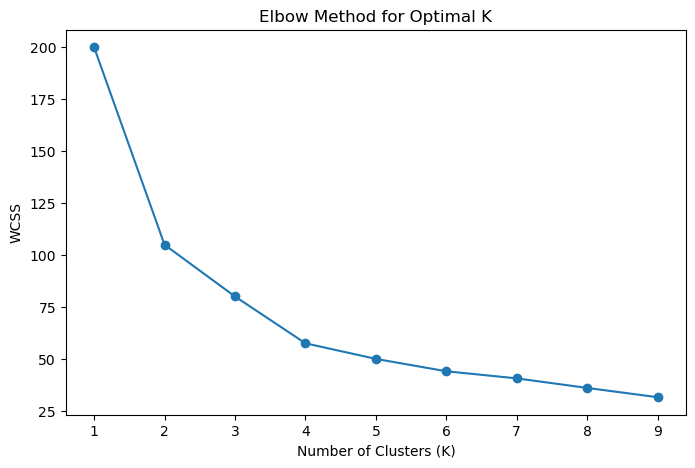

In [154]:
# Plot Elbow Method
plt.figure(figsize=(8,5))
plt.plot(range(1, 10), wcss, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K")
plt.show()

In [158]:
# Optimal k
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_unlabeled["Cluster"] = kmeans.fit_predict(df_scaled)

# Silhouette Average
silhouette_avg = silhouette_score(df_scaled, df_unlabeled["Cluster"])

# Round
k_silhouette_avg = round(silhouette_avg, 4)
print(f"Silhouette Score K: {k_silhouette_avg}")

Silhouette Score K: 0.4085


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### PCA

In [161]:
# PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
round(np.max(df_pca), 0)

3.0

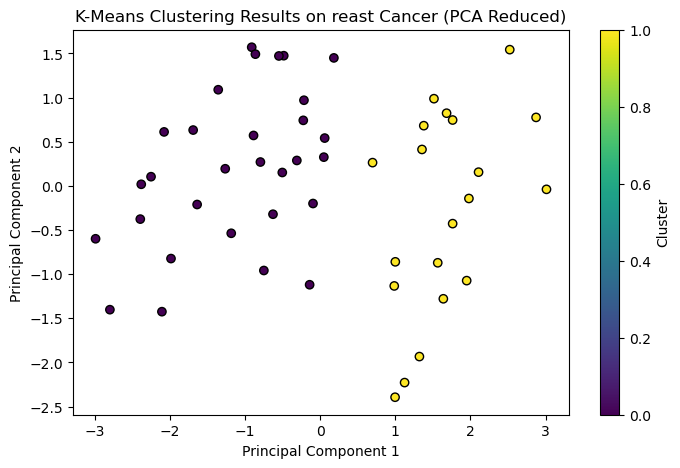

In [163]:
# Scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_unlabeled["Cluster"], cmap='viridis', marker='o', edgecolor='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering Results on reast Cancer (PCA Reduced)")
plt.colorbar(label="Cluster")
plt.show()

### GMM Analysis

In [167]:
# Clusters
arrest_data["Predicted_Cluster"] = df_unlabeled["Cluster"]
arrest_data["Actual_Label"] = arrest_data["State"]

# Return cluster comparison
#print(df.groupby(["Actual_Label", "Predicted_Cluster"]).size())
arrest_data[["Actual_Label", "Predicted_Cluster"]].value_counts().shape

(50,)

In [170]:
# GMM Analysis
bic_scores = []
k_values = range(1, 10)

# for loop
for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm.fit(df_scaled)
    bic_scores.append(gmm.bic(df_scaled))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

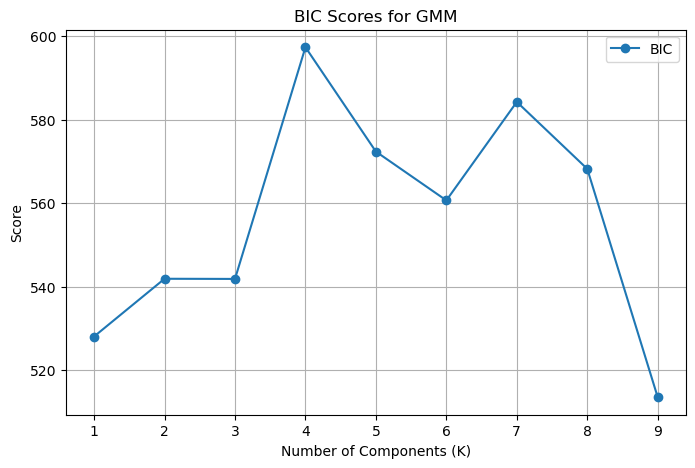

In [172]:
# Plot BIC to find optimal K
plt.figure(figsize=(8, 5))
plt.plot(k_values, bic_scores, marker='o', linestyle='-', label='BIC')
#plt.plot(k_values, aic_scores, marker='o', linestyle='-', label='AIC')
plt.xlabel('Number of Components (K)')
plt.ylabel('Score')
plt.legend()
plt.title('BIC Scores for GMM')
plt.grid(True)
plt.show()

In [174]:
# Optimal k
optimal_k =  4
gmm = GaussianMixture(n_components=optimal_k, random_state=42, n_init=10)
# fit the model
gmm.fit(df_scaled)

# Assign probabilities to each cluster
df_unlabeled["GMM_Cluster"] = gmm.predict(df_scaled)
df_unlabeled["Cluster_Probability"] = np.max(gmm.predict_proba(df_scaled), axis=1)

# Find and round the Silhouette Average
GMM_silhouette_avg = silhouette_score(df_scaled, df_unlabeled["GMM_Cluster"])
#print(f"Silhouette Score: {silhouette_avg}")
# round
round(GMM_silhouette_avg,4)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

0.226

In [176]:
# Anomalies
threshold = np.percentile(df_unlabeled["Cluster_Probability"], 5)
anomalies = df_unlabeled[df_unlabeled["Cluster_Probability"] < threshold]

# Number of anomalies
len(anomalies)

3

### Clustering

In [178]:
# Clusering with K-means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_unlabeled["KMeans_Cluster"] = kmeans.fit_predict(df_scaled)

# Compare clustering assignments
comparison = pd.crosstab(df_unlabeled["GMM_Cluster"], df_unlabeled["KMeans_Cluster"]) # use cross.tab()
# Return the shape of the value counts
comparison.shape

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(4, 4)

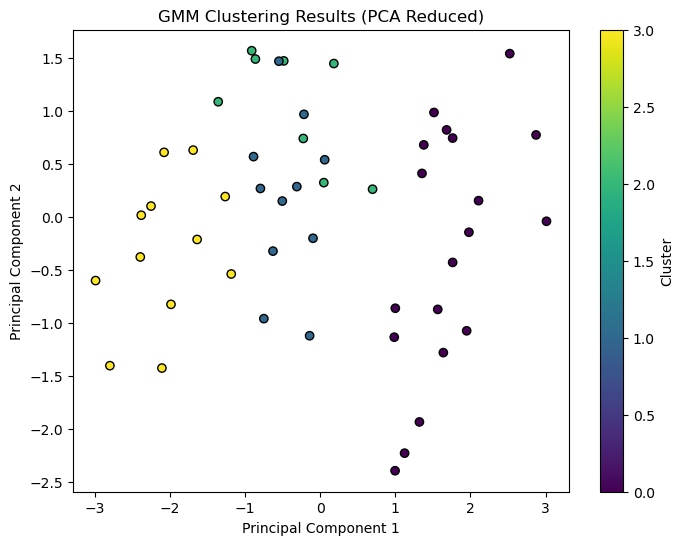

In [181]:
# plot gmm
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_unlabeled["GMM_Cluster"], cmap='viridis', marker='o', edgecolor='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("GMM Clustering Results (PCA Reduced)")
plt.colorbar(label="Cluster")
plt.show()

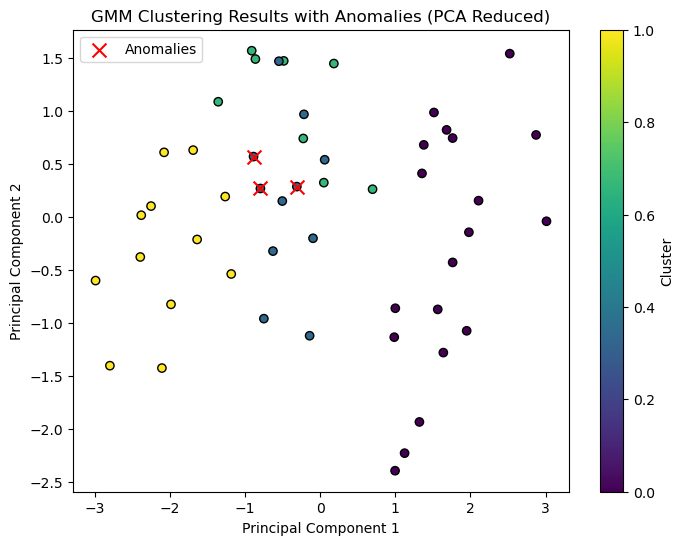

In [184]:
# plot gmm with anomalies
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_unlabeled["GMM_Cluster"], cmap='viridis', marker='o', edgecolor='k')
plt.scatter(df_pca[df_unlabeled["Cluster_Probability"] < threshold, 0],
            df_pca[df_unlabeled["Cluster_Probability"] < threshold, 1],
            color='red', marker='x', s=100, label="Anomalies")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("GMM Clustering Results with Anomalies (PCA Reduced)")
plt.colorbar(label="Cluster")
plt.legend()
plt.show()

### Conclusion

* The data (US states, for example) has been partitioned into 4 groups (“clusters”) based on the similarity of their features (Murder, Assault, UrbanPop, Rape).
* Each cluster includes states that are more similar to each other than to those in other clusters, according to the variables used.
* Silhouette Score helps gauge how well-separated and compact these clusters are:
** 0.4085: Indicates moderate clustering. There is some clear structure, but clusters may overlap or not be perfectly distinct.
** 0.226: Indicates weak clustering. There is significant overlap and/or the clusters are not well defined.

Each cluster may represent a group of states with similar crime rates or urban population characteristics.
For example, one cluster might contain states with high murder and assault rates, another with low values, and others with mixed profiles.
